In [151]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.fft import fft
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

In [152]:
# Define a function to compute the power spectral density (PSD)
def compute_psd(epochs, freq_bands, sfreq):
    psd_list = []

    for epoch in epochs:
        psd = np.abs(fft(epoch))**2
        psd_freqs = np.fft.fftfreq(epoch.shape[-1], 1 / sfreq)
        
        band_powers = []
        for band in freq_bands:
            idx = np.logical_and(psd_freqs >= band[0], psd_freqs <= band[1])
            band_power = np.sum(psd[:, idx], axis=-1)
            band_powers.append(band_power)
            
        psd_list.append(np.array(band_powers))

    return np.array(psd_list)

# Define the frequency bands of interest
freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45),
}

In [153]:
# Load all .bdf files from the folder
folder_path = 'data'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.bdf')]

X_all = []
X_psd_all = []
y_all = []
durations = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    raw = mne.io.read_raw_bdf(file_path, preload=True)

    events = mne.find_events(raw)
    event_id = {'awe': 9, 
                'frustration': 10,
                'joy': 11,
                'anger': 12,
                'happy': 13,
                'sad': 14,
                'love': 15,
                'fear': 16,
                'compassion': 17,
                'jealousy': 18,
                'content': 19,
                'grief': 20,
                'relief': 21,
                'excite': 22,
                'disgust': 23
                }
    # tymczasowo, bo niektóre pliki nie mają tego grief i wyrzuca error
    event_id_no_grief = {'awe': 9, 
            'frustration': 10,
            'joy': 11,
            'anger': 12,
            'happy': 13,
            'sad': 14,
            'love': 15,
            'fear': 16,
            'compassion': 17,
            'jealousy': 18,
            'content': 19,
            # 'grief': 20,
            'relief': 21,
            'excite': 22,
            'disgust': 23
            }
    try:
        epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, baseline=None)
    except:
        epochs = mne.Epochs(raw, events, event_id_no_grief, tmin=-0.2, tmax=0.5, baseline=None)

    X = epochs.get_data()
    X_psd = compute_psd(epochs, freq_bands.values(), epochs.info['sfreq'])
    y = epochs.events[:, -1]
    print('File', file_name, 'shape: ', X.shape, y.shape)
    X_all.append(X)
    X_psd_all.append(X_psd)
    y_all.append(y)

    # Calculate the duration of each event
    for i in range(1, len(events)):
        start_time_current_event = events[i - 1, 0]
        start_time_next_event = events[i, 0]
        duration = (start_time_next_event - start_time_current_event) / raw.info['sfreq']
        event_id = events[i - 1, 2]
        if event_id >= 9 and event_id <= 23:
            durations.append((event_id, duration))

X = np.concatenate(X_all)
X_psd = np.concatenate(X_psd_all)
y = np.concatenate(y_all)

Extracting EDF parameters from c:\Users\hubra\Documents\machine-perception\data\eeg_recording_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1155327  =      0.000 ...  4512.996 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
86 events found
Event IDs: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  30 100]
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 180 original time points ...
0 bad epochs dropped
File eeg_recording_1.bdf shape:  (15, 265, 180) (15,)
Extracting EDF parameters from c:\Users\hubra\Documents\machine-perception\data\eeg_recording_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ..

In [154]:
X.shape, X_psd.shape, y.shape

((89, 265, 180), (89, 5, 265), (89,))

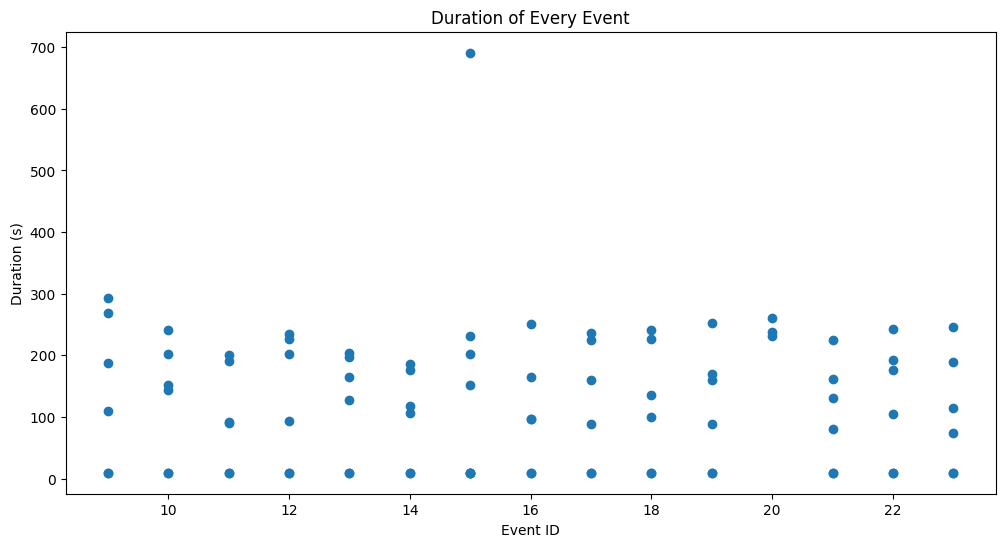

In [155]:
# Plot the duration of every event
event_ids, event_durations = zip(*durations)
plt.figure(figsize=(12, 6))
plt.scatter(event_ids, event_durations)
plt.xlabel('Event ID')
plt.ylabel('Duration (s)')
plt.title('Duration of Every Event')
plt.show()

In [156]:
def data_augmentation(X, y, n_segments, segment_duration=None, noise_std=None, random_seed=42):
    np.random.seed(random_seed)
    augmented_X = []
    augmented_y = []
    
    if segment_duration is None:
        segment_duration = int(0.5 * X.shape[2])

    if noise_std is None:
        noise_std = np.std(X) / 10

    for i in range(X.shape[0]):
        for _ in range(n_segments):
            start = np.random.randint(0, X.shape[2] - segment_duration)
            segment = X[i, :, start : start + segment_duration]
            noise = np.random.normal(0, noise_std, segment.shape)
            augmented_segment = segment + noise
            augmented_X.append(augmented_segment)
            augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)

def extract_segments(X, segment_duration):
    if segment_duration is None:
        segment_duration = int(0.5 * X.shape[2])
    n_segments = X.shape[2] // segment_duration
    extracted_X = []

    for i in range(X.shape[0]):
        for j in range(n_segments):
            start = j * segment_duration
            segment = X[i, :, start : start + segment_duration]
            extracted_X.append(segment)

    return np.array(extracted_X)


In [157]:
X.shape, data_augmentation(X, y, 8)[0].shape

((89, 265, 180), (712, 265, 90))

In [158]:
def test_all_classifiers(X, y):
    X, y = data_augmentation(X, y, 12)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)      

    # Logistic Regression
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Logistic Regression accuracy: {accuracy:.2f}')

    # Support Vector Classification
    pipeline = make_pipeline(
        StandardScaler(),
        SVC()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'SVC accuracy: {accuracy:.2f}')

In [159]:
test_all_classifiers(X, y)

C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.15
SVC accuracy: 0.09


In [160]:
test_all_classifiers(X_psd, y)

Logistic Regression accuracy: 0.08
SVC accuracy: 0.09
